In [2]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
import matplotlib.pyplot as plt
set_seed(3407)

c:\Users\mcasa\anaconda3\envs\nlpt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
input = "Michelle Jones was a top-notch student. Michelle"
print("Input:", input)
bpe = BPETokenizer()
# bpe() gets a string and returns a 2D batch tensor 
# of indices with shape (1, input_length)
tokens = bpe(input)[0]
print("Tokenized input:", tokens)
input_length = tokens.shape[-1]
print("Number of input tokens:", input_length)
# bpe.decode gets a 1D tensor (list of indices) and returns a string
print("Detokenized input from indices:", bpe.decode(tokens))  
tokens_str = []
for token in tokens:
    decoded_token = bpe.decode(torch.tensor([token]))
    tokens_str.append(decoded_token)
print("Detokenized input as strings: " + '/'.join(tokens_str))


Input: Michelle Jones was a top-notch student. Michelle
Tokenized input: tensor([48736,  5437,   373,   257,  1353,    12,  1662,   354,  3710,    13,
        16738])
Number of input tokens: 11
Detokenized input from indices: Michelle Jones was a top-notch student. Michelle
Detokenized input as strings: Michelle/ Jones/ was/ a/ top/-/not/ch/ student/./ Michelle


In [31]:
model = 'gpt2-xl'
device = "cpu"

In [32]:
model = GPT.from_pretrained(model)
model.to(device)
model.eval()
use_minigpt = True

number of parameters: 1557.61M


In [45]:

def generate(prompt='', num_samples=10, steps=20, do_sample=True):


# tokenize the input prompt into integer input sequence
    tokenizer = BPETokenizer()
    if prompt == '':
        # to create unconditional samples...
        # manually create a tensor with only the special <|endoftext|> token
        # similar to what openai's code does here https://github.com/openai/gpt-2/blob/master/src/generate_unconditional_samples.py
        x = torch.tensor([[tokenizer.encoder.encoder['<|endoftext|>']]], dtype=torch.long)
    else:
        x = tokenizer(prompt).to(device)
    
    # we'll process all desired num_samples in a batch, so expand out the batch dim
    x = x.expand(num_samples, -1)

    # forward the model `steps` times to get samples, in a batch
    y = model.generate(x, max_new_tokens=steps, do_sample=do_sample, top_k=40)
    
    # Write outputs to file
    with open('output2.txt', 'a', encoding='utf-8') as f:
        f.write('-------------------------- Prompt: ' + prompt + '-----------------\n\n')
        for i in range(num_samples):
            out = tokenizer.decode(y[i].cpu().squeeze())
            print('-'*80)
            print(out)
            f.write(out + '\n' + '-' * 80 + '\n')
        f.write('\n\n\n\n')
        

In [46]:
inputs =['Michelle Jones was a top-notch student. Michelle',
         'Michelle Smith was a top-notch student. Michelle',
         'Jessica Jones was a top-notch student. Michelle',
         'Michelle Smith was a top-notch student. Jessica']

for input in inputs:
    generate(prompt=input, num_samples=5, steps=20, do_sample=True)

--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle graduated with a degree in criminal justice in June 2014, but she's not back in school this semester
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle was a member of our varsity volleyball team, and she was a member of our club tennis team
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle started at the University of Southern California at the end of the 9th grade. She was a freshman
--------------------------------------------------------------------------------
Michelle Jones was a top-notch student. Michelle was smart, she had a good personality, she worked hard, she got good grades, and she
--------------------------------------------------------------------------------
Michelle Jones was a top-n

# Implementation for the experiment

number of parameters: 124.44M


C:\Users\mcasa\AppData\Local\Temp\ipykernel_13516\4261284214.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(inputs).unsqueeze(0).to(device)  # Convert list to tensor, add batch dimension, and move to device


Clean logics shape: torch.Size([10, 50257])
Clean IDs shape: torch.Size([1, 11])
Shape for probs: torch.Size([10, 50257])
Shape for token_ids: torch.Size([1, 11])
Shape for probs: torch.Size([10, 50257])
Shape for token_ids: torch.Size([1, 11])


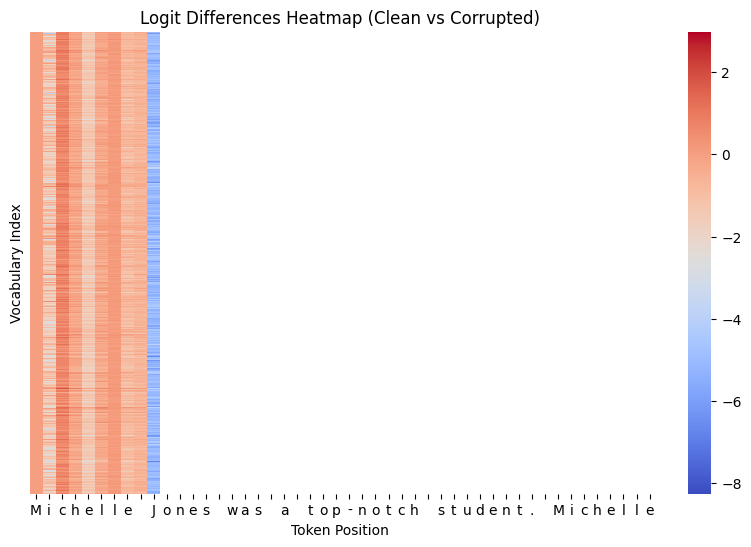

AssertionError: 

In [130]:
import torch
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import BPETokenizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load GPT-2 model and tokenizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BPETokenizer()
model = GPT.from_pretrained('gpt2')
model.eval()

# Define clean and corrupted texts
clean_text = "Michelle Jones was a top-notch student. Michelle"
corrupted_text = "Michelle Smith was a top-notch student. Michelle"

def get_token_logits(text):
    # Tokenize the text using BPETokenizer
    inputs = tokenizer(text)  # Get a list of token IDs

    input_ids = torch.tensor(inputs).unsqueeze(0).to(device)  # Convert list to tensor, add batch dimension, and move to device

    with torch.no_grad():
        outputs = model.forward(input_ids[0])  # Get logits from the model
    
    # The output is likely a tuple, so we need to unpack it
    logits = outputs[0]  # The logits are typically the first element in the tuple

    logits = logits[0, :-1, :]  # Extract logits for all tokens except the last one
    return logits, input_ids[0]



# Get logits for clean and corrupted inputs
clean_logits, clean_ids = get_token_logits(clean_text)
corrupted_logits, corrupted_ids = get_token_logits(corrupted_text)

print("Clean logics shape:", clean_logits.shape)

print("Clean IDs shape:", clean_ids.shape)


# Convert logits to probabilities
def get_token_probabilities(logits, token_ids):
    # Apply softmax to convert logits to probabilities
    probs = torch.nn.functional.softmax(logits, dim=-1)
    print("Shape for probs:", probs.shape)
    print("Shape for token_ids:", token_ids.shape)

    # Fix token_ids to match the sequence length of logits (10 tokens, not 11)
    token_ids = token_ids.squeeze(0)  # Remove the batch dimension (shape becomes [11])
    
    # Remove the first token, which is often padding or a special token
    token_ids = token_ids[1:]  # Now token_ids has shape [10], matching the sequence length of probs

    # Gather probabilities for the specific tokens in the sequence
    token_probs = torch.gather(probs, dim=-1, index=token_ids.unsqueeze(-1))  # Skip the first token
    return token_probs.cpu().numpy()

clean_probs = get_token_probabilities(clean_logits, clean_ids)
corrupted_probs = get_token_probabilities(corrupted_logits, corrupted_ids)

# Compute logit differences
logit_diff = (clean_logits - corrupted_logits).cpu().numpy()
prob_diff = (clean_probs - corrupted_probs)

logit_diff = torch.tensor(logit_diff)
prob_diff = torch.tensor(prob_diff)



# Visualize the results
plt.figure(figsize=(10, 6))
sns.heatmap(logit_diff.squeeze(0).T, cmap="coolwarm", annot=False, xticklabels=tokenizer.decode(clean_ids[0]), yticklabels=False)
plt.title("Logit Differences Heatmap (Clean vs Corrupted)")
plt.xlabel("Token Position")
plt.ylabel("Vocabulary Index")
plt.show()

# Print analysis results for token probabilities
for i, (clean, corrupt, diff) in enumerate(zip(clean_probs, corrupted_probs, prob_diff)):
    token = tokenizer.decode(clean_ids[0][i])
    print(f"Token: {token} | Clean Prob: {clean:.4f} | Corrupt Prob: {corrupt:.4f} | Diff: {diff:.4f}")
